# Nearest Neighbor investigation

This is a sanity check where we investigate the "representational power" of the embeddings.

Simply, we just use the trained network, generate the image emebddings and then given a query image we check what similar images we get from the dataset

*(tip: it is always interesting to check the case when you don't load a model and use the random initialization)*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from tqdm import tqdm

import barlow_twins

# Model

In [2]:
weights = "/code/logs_full_run/test_sgd/checkpoint.h5"
include_projection_layer = False

In [3]:
model = barlow_twins.BarlowTwinsModel(224, 224, 8192, False, ~include_projection_layer)

In [4]:
dummy_input = np.zeros((1, 224, 224, 3), dtype=np.float32)
model.build(dummy_input.shape)
dummy_output = model(dummy_input)
_, embedding_dims = dummy_output.shape

In [5]:
model.load_weights(weights, by_name=True)

# Dataset

In [6]:
dataset, nb_images = barlow_twins.create_dataset("/data", 224, 224, 1, test_dataset=True)

In [7]:
print(f"Number of images: {nb_images}")

Number of images: 8189


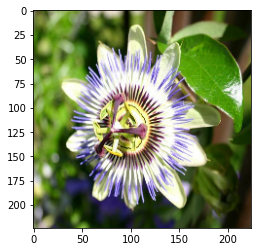

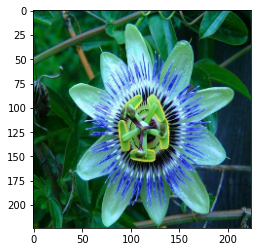

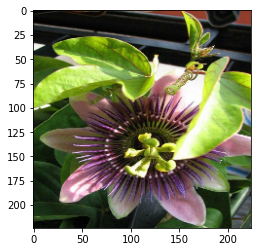

In [8]:
for x in dataset.take(3):
    x = x[0].numpy().astype(np.uint8)
    plt.figure()
    plt.imshow(x)

# Nearest Neighbor investigation

In [9]:
N = 1000

embeddings = np.zeros((N, embedding_dims), dtype=np.float32)
images = np.zeros((N, 224, 224, 3), dtype=np.uint8)

for i, x in tqdm(enumerate(dataset.take(N))):
    # TODO: with batched processing this can be much faster
    pred = model(x)[0].numpy().astype(np.float32)
    embeddings[i, :] = pred
    images[i, :, :, :] = x[0].numpy().astype(np.uint8)

1000it [00:14, 68.35it/s]


In [10]:
tree = KDTree(embeddings)

In [14]:
query_embedding_index = 1

In [15]:
sim_dst, sim_indices = tree.query(np.expand_dims(embeddings[query_embedding_index], 0), k=9)
sim_dst = sim_dst[0]
sim_indices = sim_indices[0]

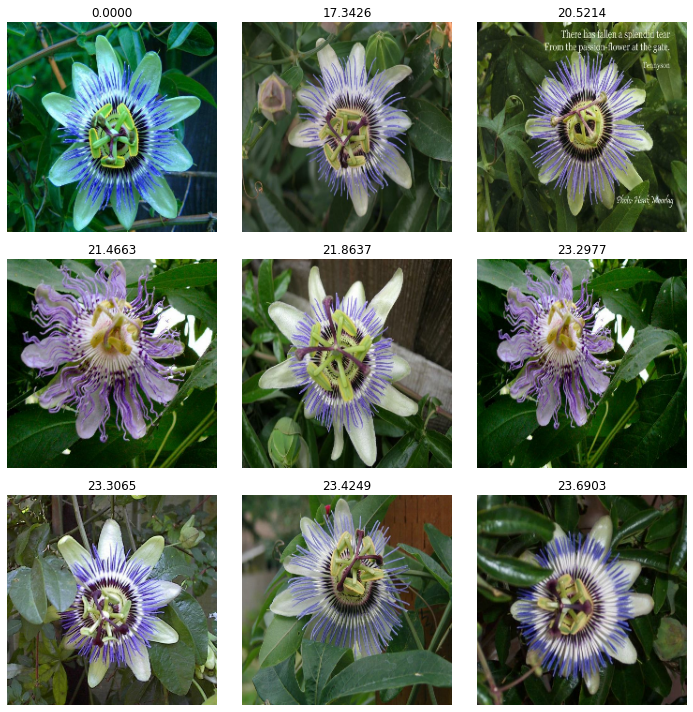

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()

for i in range(len(sim_indices)):
    axs[i].imshow(images[sim_indices[i]])
    axs[i].set_title(f"{sim_dst[i]:.4f}")
    axs[i].axis("off")
fig.tight_layout()